<h1>AS24 Data Analysis and Modelling

With the data in hand, we wish to analyse the data and check if modelling the data to predict either the 'product_tier' or the 'detail_views' is possible.

This notebook documents the code necessary for a Exploratory Data Analsysis, Modelling and Model Evalution.

To re-run the notebook, please follow the steps README.md file run the notebook inside a virtual environment.

<h3>Imports and Data Loading

Importing the necessary libraries

In [1]:
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import timedelta

In [2]:
sns.set_style('whitegrid')

In [3]:
DATA_PATH = r"data/"

In [4]:
os.listdir(DATA_PATH)

['AS24_Case_Study_Data.csv', 'AS24_Data_Description.csv']

<h3>Data Analysis and Cleaning

The below set of codes, focuses on analysis of the data at hand, performing EDA using Seaborn and manipulation of data for cleaning purposes.

In [5]:
df = pd.read_csv(DATA_PATH+os.listdir(DATA_PATH)[0])

In [6]:
df.head()

,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
0,350625839,Basic,Mitsubishi,16750,5,2013,24.07.18,24.08.18,3091.0,123.0,30,0.0378033
1,354412280,Basic,Mercedes-Benz,35950,4,2015,16.08.18,07.10.18,3283.0,223.0,52,0.067925678
2,349572992,Basic,Mercedes-Benz,11950,3,1998,16.07.18,05.09.18,3247.0,265.0,51,0.081613797
3,350266763,Basic,Ford,1750,6,2003,20.07.18,29.10.18,1856.0,26.0,101,0.014008621
4,355688985,Basic,Mercedes-Benz,26500,3,2014,28.08.18,08.09.18,490.0,20.0,12,0.040816327


The first step to understanding the data is looking at the data types of the various columns and then checking if data type of the column matches with that of the data in the column.

First, I select the non-object i.e. non-string/date type data.

In [7]:
df.select_dtypes(exclude=['object']).columns

Index(['article_id', 'price', 'first_zip_digit', 'first_registration_year',
       'search_views', 'detail_views', 'stock_days'],
      dtype='object')

From the above selection of float or integer type data, we can see that eventhough <b>ctr</b> has float type data, it is not selected.

We need to investigate the cause and rectify the problem.

In [8]:
df.ctr.dtype

dtype('O')

We can see that the datatype of the column is of type 'O' i.e. object. The fact that we have float data and yet an 'O' datatype is a clear indication that there are non string type garbage values in some of the cells.

We need to see what type of string type values exists.

Below function is just a method created to mark the values that cannot be converted to float. 

In [9]:
def isfloat(val):
    try:
        val = float(val)
        return True
    except:
        return False

In [10]:
df['ctr'] = df['ctr'].astype(str)
print(df.ctr[~df.ctr.apply(isfloat)].values.tolist()[0:5])

['27.624.309.392.265.100', '4.086.021.505.376.340', '30.066.815.144.766.100', '5.126.118.795.768.910', '1.485.148.514.851.480']


Our assumption that the <b>ctr</b> column has some garbage noise, was correct. As these values seem to be random. The only possible solution to rectify the <b>ctr</b> column is to re-calculate it.

Based on the description from <i>'AS24_Data_Description.csv'</i>, <b>ctr</b>:

$$ctr = \frac{detail\_views}{search\_views}$$

In [11]:
df["ctr"] = df.detail_views/df.search_views

The next step should be to check the null values. If there are any null values, we need to either fill them wirh appropriate values or remove them.

In [12]:
df.isna().sum()

article_id                  0
product_tier                0
make_name                   0
price                       0
first_zip_digit             0
first_registration_year     0
created_date                0
deleted_date                0
search_views               10
detail_views               10
stock_days                  0
ctr                        24
dtype: int64

There are some null value for <b>search_views</b>, <b>detail_views</b> and <b>ctr</b>. The number of nulls are higher than that of search_views and detail_views. The possible problem might be that there are some divide by zero issues for ctr. We will try to fix them.

For the <b>search_views</b>, <b>detail_views</b> we would need to check the data distribution.

<AxesSubplot:xlabel='search_views'>

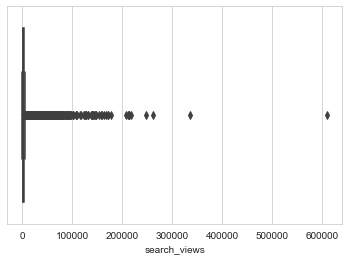

In [13]:
sns.boxplot(df.search_views)

<AxesSubplot:xlabel='detail_views'>

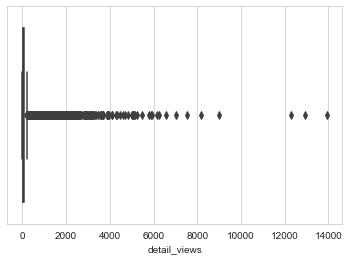

In [14]:
sns.boxplot(df.detail_views)

Based on the box plot for <b>search_views</b> and <b>detail_views</b>, one can understand that the data is not normal. So imputation of null values with mean or median would not be fruitful.

The best case would be to ignore where we have either of those columns as null.

In [15]:
df = df[~df.ctr.isna()]

Removing the divide by zero issue with <b>ctr</b>:


In [16]:
df.ctr[(df.search_views == 0) & (df.detail_views == 0)] = 0

Checking for null values again, now we should have zero null values for all columns. This would also make our assumption of divide by zero for <b>ctr</b>, true.

In [17]:
df.isna().sum()

article_id                 0
product_tier               0
make_name                  0
price                      0
first_zip_digit            0
first_registration_year    0
created_date               0
deleted_date               0
search_views               0
detail_views               0
stock_days                 0
ctr                        0
dtype: int64

Checking the sanity of <b>first_registration_year</b> column.

<AxesSubplot:xlabel='first_registration_year'>

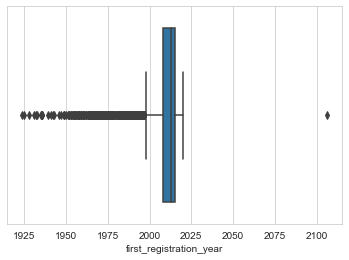

In [18]:
sns.boxplot(df.first_registration_year)

We can notice, that the outlier for the <b>first_registration_year</b> is as as far as that galaxy, far far away.

In [19]:
df.first_registration_year.max(), df.first_registration_year.min()

(2106, 1924)

In [20]:
df.first_registration_year[df.first_registration_year > 2019]

36302    2106
77691    2020
Name: first_registration_year, dtype: int64

<b>2106</b> it is. Probably as mistype of <b>2016</b>. Fixing it below:

In [21]:
df.first_registration_year[df.first_registration_year == 2106] = 2016

Checking the sanity of <b>stock_days</b> column.

<AxesSubplot:xlabel='stock_days'>

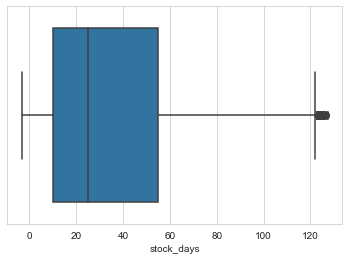

In [22]:
sns.boxplot(df.stock_days)

<b>stock_days</b> is the number of days for which the article was listed. It is highly unlikely, and pretty much against the Second Law of Thermodynamics that a listing is deleted before even being created. 

The fact that the first quantile, has value in negative is a red flag. Checking actual number of rows which have negative <b>stock_days</b> values.

In [23]:
df[df.stock_days < 0].shape[0]

91

Recalculating the <b>stock_days</b> column. First, we need to convert the dates into the native pandas format and then get the difference of days.

According to the description csv file provided, <b>stock_days</b> can be calculated as:

$$stock\_days = num\_days(deleted\_date - created\_date)$$

Converting <b>created_date</b> and <b>deleted_date</b> to native Pandas date format.

In [24]:
df.created_date = pd.to_datetime(df.created_date, format='%d.%m.%y').dt.date
df.deleted_date = pd.to_datetime(df.deleted_date, format='%d.%m.%y').dt.date

Recalculating <b>stock_days</b>:

In [25]:
df.stock_days = (df.deleted_date - df.created_date) / timedelta(1)

In [26]:
df[df.stock_days < 0].shape[0]

0

The above, code snippet suggests that the issue with <b>stock_days</b> was solved.

Checking sanity of <b>make_name</b> column:

In [27]:
df.make_name.nunique()

91

There are too many categorical values for <b>make_name</b>. We would need to use some appropriate embeddings for them instead of concerting the column to dummies, as that would lead to a data explosion (91 new columns).

We would consider feature engineering them in the feature engineering module.

First, we create a countplot to see the data distribution for <b>make_name</b> column:

(array([    0.,  2000.,  4000.,  6000.,  8000., 10000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

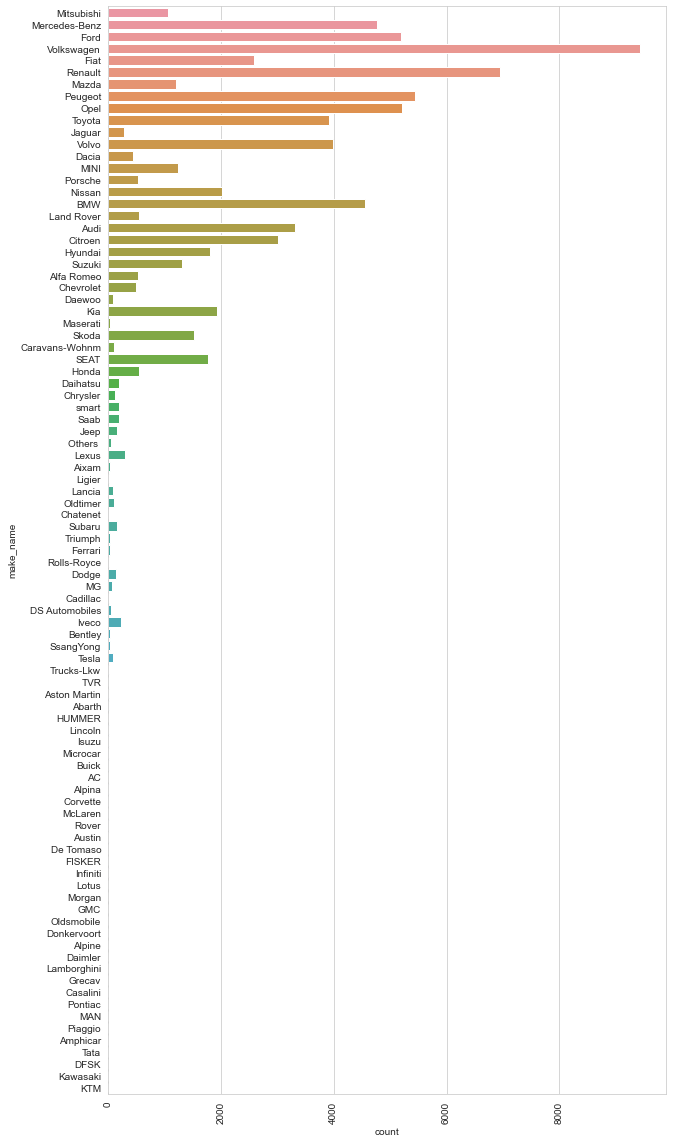

In [28]:
fig = plt.figure(figsize = (10,20))
sns.countplot(y=df.make_name)
plt.xticks(rotation=90)

As the data distribution is very skewed, we need to have a closer look for any anomalies anc check some unusual values.

In [29]:
make_count_df = pd.DataFrame(df.make_name.value_counts()).reset_index().rename(columns=
                                                                               {"index": "make_name", 
                                                                                "make_name": "count_article"})
print(make_count_df[make_count_df.count_article <= 0])
make_count_df.sort_values("count_article", ascending=True).head()

Empty DataFrame
Columns: [make_name, count_article]
Index: []


,make_name,count_article
90,KTM,1
79,Amphicar,1
80,Casalini,1
81,Grecav,1
82,Tata,1


We do not find any issues with the count of the make_name. Also a visual inspection, reveals that no duplications due to minor spelling errors exist for <b>make_name</b>

In [30]:
df.head()

,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
0,350625839,Basic,Mitsubishi,16750,5,2013,2018-07-24,2018-08-24,3091.0,123.0,31.0,0.039793
1,354412280,Basic,Mercedes-Benz,35950,4,2015,2018-08-16,2018-10-07,3283.0,223.0,52.0,0.067926
2,349572992,Basic,Mercedes-Benz,11950,3,1998,2018-07-16,2018-09-05,3247.0,265.0,51.0,0.081614
3,350266763,Basic,Ford,1750,6,2003,2018-07-20,2018-10-29,1856.0,26.0,101.0,0.014009
4,355688985,Basic,Mercedes-Benz,26500,3,2014,2018-08-28,2018-09-08,490.0,20.0,11.0,0.040816


Understanding the data description for columns with continous values. 

In [31]:
df.describe()

,article_id,price,first_zip_digit,first_registration_year,search_views,detail_views,stock_days,ctr
count,7.829700e+04,78297.000000,78297.000000,78297.000000,78297.00000,78297.000000,78297.000000,78297.000000
mean,3.574864e+08,15069.670358,4.631876,2011.089186,2297.91333,93.486583,35.993767,0.046892
std,5.076809e+06,16375.598837,2.354368,6.529858,6339.52668,228.042547,32.213028,0.038818
min,3.472324e+08,50.000000,1.000000,1924.000000,1.00000,0.000000,0.000000,0.000000
25%,3.536387e+08,5750.000000,3.000000,2008.000000,368.00000,13.000000,10.000000,0.024263
50%,3.585479e+08,10909.000000,5.000000,2013.000000,920.00000,36.000000,25.000000,0.038239
75%,3.614817e+08,18890.000000,7.000000,2015.000000,2234.00000,94.000000,55.000000,0.058687
max,3.647040e+08,249888.000000,9.000000,2020.000000,608754.00000,13926.000000,126.000000,1.833333


Understanding the data description for columns with object data type.

In [32]:
df.select_dtypes('object').describe()

,product_tier,make_name,created_date,deleted_date
count,78297,78297,78297,78297
unique,3,91,35,273
top,Basic,Volkswagen,2018-11-16,2018-12-01
freq,75397,9424,3442,947


Understaning distribution of product_tier.

Text(0.5, 0, 'Product Tier')

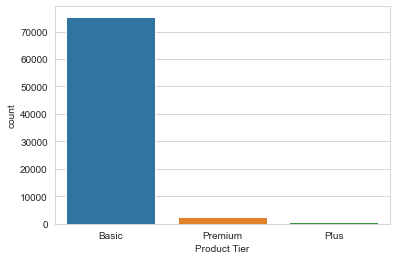

In [33]:
fig = plt.figure(figsize=(6, 4))

ax = sns.countplot(df.product_tier)
plt.xlabel("Product Tier")

There seems to be a huge disparity with the value counts for product_tier. This would create issues when modelling the data to predict product_tier. Let's have a value counts for the same to confirm.

In [34]:
df.product_tier.value_counts()

Basic      75397
Premium     2324
Plus         576
Name: product_tier, dtype: int64

We might need to model the data with class weights for product_tier or over sample the data over product_tier.

Investigating the relationship between <b>search_views</b> and <b>detail_views</b>

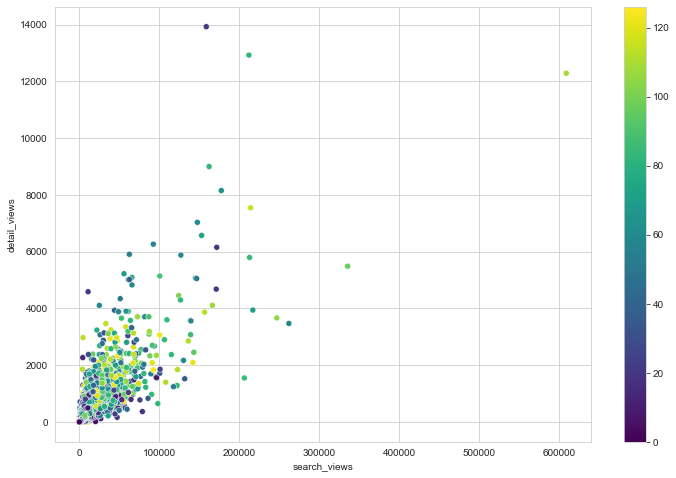

In [35]:
fig = plt.figure(figsize=(12,8))
ax = sns.scatterplot(x='search_views', y='detail_views', data=df, hue="stock_days", palette="viridis")
norm = plt.Normalize(df['stock_days'].min(), df['stock_days'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])

ax.get_legend().remove()
ax.figure.colorbar(sm)
plt.show()

This plot seems great, it somewhat tells us that it would be easier to train a model to predict <b>detail_views</b> as there is a linear relationship between <b>search_views</b> and <b>detail_views</b>

However, their relationship gets stronger with how many days the article was listed. Is is somewhat true too, as for the longer time we have a listing. The more search view and the more detail views.

Lets now investigate the same relationship with respect to price. The ideal assumption would be that higher the price, more shall be the search_views and lower will be the detail_views

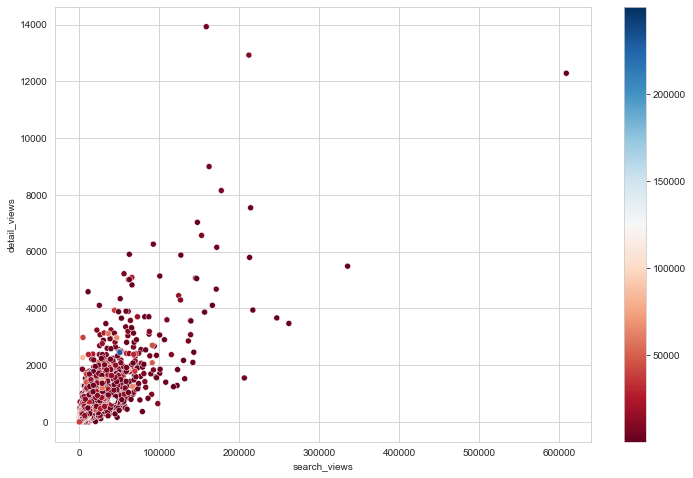

In [36]:
fig = plt.figure(figsize=(12,8))
ax = sns.scatterplot(x='search_views', y='detail_views', data=df, hue="price", palette='RdBu')
norm = plt.Normalize(df['price'].min(), df['price'].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

ax.get_legend().remove()
ax.figure.colorbar(sm)
plt.show()

The assumption that lower price articles will have a higher search and details view is correct.

Understanding the co-relation heat map to check if there is a strong multi-colinearity.

<AxesSubplot:>

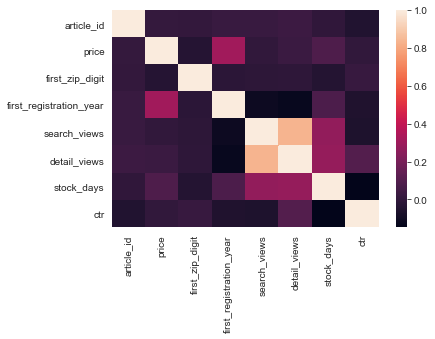

In [37]:
sns.heatmap(df.corr())

There doesn't seem to be a very hih degree of multi-colinearity but some need to be dealt with while creating a regression model.

Understanding the relationship between <b>price</b> and <b>first_registration_year</b>. 
The above heatmap suggested there is a positive relationship between both the features/columns.

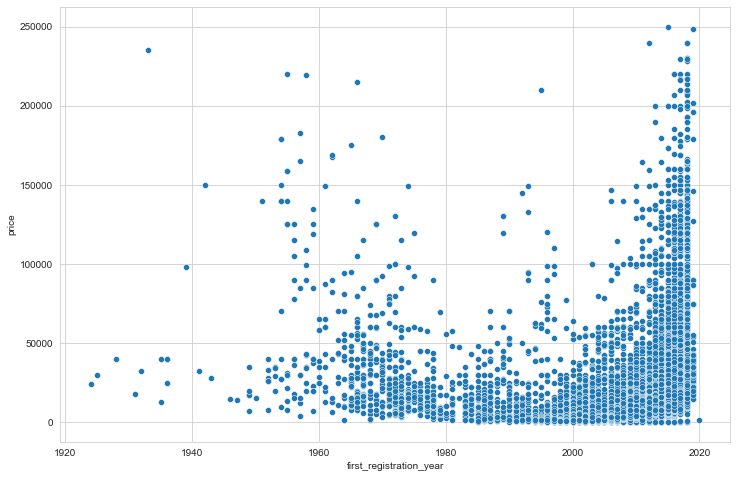

In [38]:
fig = plt.figure(figsize=(12,8))
ax = sns.scatterplot(x='first_registration_year', y='price', data=df)
plt.show()

Lastly, checking that <b>article_id</b> is truly unique.

In [39]:
df.article_id.nunique(), df.shape[0]

(78281, 78297)

<b><i>Oopie!

The reason there can be duplicates with respect to <b>article_id</b> is that they were created by mistake. Let's analyse the duplicated data.

In [40]:
df[df.duplicated(subset="article_id", keep=False)].sort_values(
                                ["article_id", 'stock_days'], ascending=[True, False])

,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
39745,350214314,Basic,Opel,8250,5,2012,2018-07-20,2018-08-01,134.0,10.0,12.0,0.074627
50392,350214314,Premium,Opel,8250,5,2012,2018-07-20,2018-07-26,67.0,5.0,6.0,0.074627
63500,350214315,Basic,Nissan,13650,5,2009,2018-07-20,2018-08-01,368.0,16.0,12.0,0.043478
15997,350214315,Premium,Nissan,13650,5,2009,2018-07-20,2018-07-26,184.0,8.0,6.0,0.043478
66323,354755822,Basic,Mercedes-Benz,6950,7,2005,2018-08-20,2018-10-20,5654.0,404.0,61.0,0.071454
39922,354755822,Plus,Mercedes-Benz,6950,7,2005,2018-08-20,2018-10-18,2827.0,202.0,59.0,0.071454
9440,354755824,Basic,Toyota,10950,7,2010,2018-08-20,2018-10-20,4784.0,222.0,61.0,0.046405
70393,354755824,Plus,Toyota,10950,7,2010,2018-08-20,2018-10-18,2392.0,111.0,59.0,0.046405
6451,354755829,Basic,Ford,10950,7,2009,2018-08-20,2018-10-20,5126.0,242.0,61.0,0.047210
33971,354755829,Plus,Ford,10950,7,2009,2018-08-20,2018-10-18,2563.0,121.0,59.0,0.047210


After a deeper looks, it seems that a user might have had created listing for an artcle with product_tier as premium, but in actuality the article was basic.  This is evident because the row with basic <b>product_tier</b> is listed for more number of days.

Keeping this assumption we only take one row from the dupliacted rows which has higher <b>stock_days</b> value.

In [41]:
df_non_duplicated = df[~df.article_id.isin(df[df.duplicated(subset="article_id")].article_id.values.tolist())]

In [42]:
df_non_duplicated.shape

(78265, 12)

In [43]:
df_duplicated_and_cleaned = df[df.duplicated(subset="article_id", keep=False)].sort_values(
                                ["article_id", 'stock_days'], ascending=[True, False]).drop_duplicates(subset='article_id')

In [44]:
df = pd.concat([df_non_duplicated, df_duplicated_and_cleaned]).reset_index(drop=True).set_index('article_id')

In [45]:
df.shape

(78281, 11)

At last. Let's simply get rid of all the duplicate rows.

In [46]:
df = df.drop_duplicates()

In [47]:
df.shape

(78268, 11)

<h3>Feature Engineering

With data cleaning out of the way, lets work on some feature engineering. The major things we wish to do are:
* Create categorical embeddings for <b>make_name</b>. Simply creating dummies, would lead to a data explosion which would only make the modelling heavy. We 91 unique make_names, compressing the data onto 20 dimension would be appropriate going by the rule of 1/5 compression while creating embeddings.
* Converting <b>create_date</b> and <b>delete_date</b> to unix time. Converting them to unix time will make them continous. Which would be easier to model.
* Label encoding the <b>product_tier</b> column. We can label encode them as the data in the column is ordinal.

In [48]:
import time
from datetime import datetime
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense,Input
from sklearn.preprocessing import StandardScaler

<h5>Categorical Embeddings for make_name

First we create dummies for the <b>make_name</b> column.

In [49]:
dummy_data = pd.get_dummies(df.make_name,prefix='make_name')
dummy_data.shape[1]

91

Defining the Auto-Encoder model arhictecture for categorical embedding. The architecture is to be created using Keras and has Tensorflow in the backend.

We would be creating 20 embeddings for the 91 different make_names.

In [50]:
embedding_dim = 20

inputs = Input(shape=(dummy_data.shape[1],))

dense1 = Dense(15,activation='relu')(inputs)

embedded_output = Dense(embedding_dim)(dense1)

outputs = Dense(dummy_data.shape[1],activation='softmax')(embedded_output)

model = Model(inputs=inputs,outputs=outputs)

embedder = Model(inputs=inputs,outputs=embedded_output)

Compiling and training the model.

In [51]:
model.compile(optimizer='adam',loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(dummy_data, dummy_data, epochs=30, batch_size=100, verbose=1)

Epoch 1/30
783/783 [==============================] - 2s 2ms/step - loss: 2.5224 - accuracy: 0.4567
Epoch 2/30
783/783 [==============================] - 2s 2ms/step - loss: 0.0980 - accuracy: 0.9854
Epoch 3/30
783/783 [==============================] - 2s 2ms/step - loss: 0.0292 - accuracy: 0.9953
Epoch 4/30
783/783 [==============================] - 2s 2ms/step - loss: 0.0133 - accuracy: 0.9983
Epoch 5/30
783/783 [==============================] - 2s 2ms/step - loss: 0.0080 - accuracy: 0.9987
Epoch 6/30
783/783 [==============================] - 2s 2ms/step - loss: 0.0052 - accuracy: 0.9992
Epoch 7/30
783/783 [==============================] - 2s 2ms/step - loss: 0.0040 - accuracy: 0.9993
Epoch 8/30
783/783 [==============================] - 2s 2ms/step - loss: 0.0024 - accuracy: 0.9996
Epoch 9/30
783/783 [==============================] - 2s 2ms/step - loss: 0.0012 - accuracy: 0.9999
Epoch 10/30
783/783 [==============================] - 2s 2ms/step - loss: 0.0011 - accuracy: 0.9998

Creating the embeddings.

In [52]:
low_dim_make_name = pd.DataFrame(embedder.predict(dummy_data),columns=["make_name_"+str(x) for x in range(1,embedding_dim+1)])
low_dim_make_name.head()

,make_name_1,make_name_2,make_name_3,make_name_4,make_name_5,make_name_6,make_name_7,make_name_8,make_name_9,make_name_10,make_name_11,make_name_12,make_name_13,make_name_14,make_name_15,make_name_16,make_name_17,make_name_18,make_name_19,make_name_20
0,-3.710649,-0.024672,4.645800,-0.087067,7.460718,3.172307,1.097641,-5.611894,-2.949456,-4.423004,2.038804,-0.328514,-6.913472,-1.007811,2.699811,4.843570,-3.553567,-6.755898,-1.248509,2.198829
1,1.400417,-0.563003,4.329996,3.249180,0.952366,-3.442883,1.222669,4.612895,3.599152,2.588114,-4.467040,4.215556,-5.687446,0.039666,-1.977337,10.351012,4.966607,-5.550188,1.482608,1.104357
2,1.400417,-0.563003,4.329996,3.249180,0.952366,-3.442883,1.222669,4.612895,3.599152,2.588114,-4.467040,4.215556,-5.687446,0.039666,-1.977337,10.351012,4.966607,-5.550188,1.482608,1.104357
3,1.625196,2.229594,2.391122,3.361425,4.082112,-1.147433,2.242140,4.968598,3.360521,3.804041,1.186332,0.980249,-5.983824,3.059415,2.120267,2.522239,-1.003110,-7.841728,1.359150,-1.521092
4,1.400417,-0.563003,4.329996,3.249180,0.952366,-3.442883,1.222669,4.612895,3.599152,2.588114,-4.467040,4.215556,-5.687446,0.039666,-1.977337,10.351012,4.966607,-5.550188,1.482608,1.104357


<h5>Converting date to Unix time.

In [53]:
def get_unix_time(d):
    return int(time.mktime(datetime.strptime(str(d), "%Y-%m-%d").timetuple()))

In [54]:
df.created_date = df.created_date.apply(get_unix_time)
df.deleted_date = df.deleted_date.apply(get_unix_time)

<h5>Scaling the data

First, we define the standard scaler.

In [55]:
scaler = StandardScaler()

First we need to get all the columns with continous data and then concatenate it with the embeddings for make_name

In [56]:
continous_data = df.select_dtypes(exclude=['object'])
continous_data.head()

,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
article_id,,,,,,,,,
350625839,16750,5,2013,1532370600,1535049000,3091.0,123.0,31.0,0.039793
354412280,35950,4,2015,1534357800,1538850600,3283.0,223.0,52.0,0.067926
349572992,11950,3,1998,1531679400,1536085800,3247.0,265.0,51.0,0.081614
350266763,1750,6,2003,1532025000,1540751400,1856.0,26.0,101.0,0.014009
355688985,26500,3,2014,1535394600,1536345000,490.0,20.0,11.0,0.040816


In [57]:
continous_data = pd.concat([continous_data.reset_index(), 
                            low_dim_make_name.reset_index(drop=True)], axis=1).set_index("article_id")
continous_data.head()

,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr,make_name_1,...,make_name_11,make_name_12,make_name_13,make_name_14,make_name_15,make_name_16,make_name_17,make_name_18,make_name_19,make_name_20
article_id,,,,,,,,,,,,,,,,,,,,,
350625839,16750,5,2013,1532370600,1535049000,3091.0,123.0,31.0,0.039793,-3.710649,...,2.038804,-0.328514,-6.913472,-1.007811,2.699811,4.843570,-3.553567,-6.755898,-1.248509,2.198829
354412280,35950,4,2015,1534357800,1538850600,3283.0,223.0,52.0,0.067926,1.400417,...,-4.467040,4.215556,-5.687446,0.039666,-1.977337,10.351012,4.966607,-5.550188,1.482608,1.104357
349572992,11950,3,1998,1531679400,1536085800,3247.0,265.0,51.0,0.081614,1.400417,...,-4.467040,4.215556,-5.687446,0.039666,-1.977337,10.351012,4.966607,-5.550188,1.482608,1.104357
350266763,1750,6,2003,1532025000,1540751400,1856.0,26.0,101.0,0.014009,1.625196,...,1.186332,0.980249,-5.983824,3.059415,2.120267,2.522239,-1.003110,-7.841728,1.359150,-1.521092
355688985,26500,3,2014,1535394600,1536345000,490.0,20.0,11.0,0.040816,1.400417,...,-4.467040,4.215556,-5.687446,0.039666,-1.977337,10.351012,4.966607,-5.550188,1.482608,1.104357


Fitting the scaler.

In [58]:
scaler.fit(continous_data)

StandardScaler()

Transforming the data

In [59]:
continous_data_scaled = pd.DataFrame(scaler.transform(continous_data), columns=continous_data.columns)

In [60]:
continous_data_scaled.head()

,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr,make_name_1,...,make_name_11,make_name_12,make_name_13,make_name_14,make_name_15,make_name_16,make_name_17,make_name_18,make_name_19,make_name_20
0,0.102448,0.156695,0.292605,-1.247137,-1.102242,0.126130,0.130023,-0.155039,-0.183113,-1.417596,...,0.613063,-1.046168,-0.818965,-0.481697,1.062860,-0.249464,-2.322947,-0.060277,-0.249907,1.149518
1,1.274780,-0.268055,0.598864,-0.731555,-0.302309,0.156510,0.569180,0.496921,0.541577,0.416229,...,-1.277599,0.149757,-0.385354,-0.155951,-0.486298,1.473048,1.008842,0.461796,0.522901,0.727012
2,-0.190635,-0.692805,-2.004339,-1.426470,-0.884079,0.150814,0.753626,0.465875,0.894178,0.416229,...,-1.277599,0.149757,-0.385354,-0.155951,-0.486298,1.473048,1.008842,0.461796,0.522901,0.727012
3,-0.813436,0.581445,-1.238691,-1.336804,0.097658,-0.069288,-0.295958,2.018161,-0.847308,0.496878,...,0.365327,-0.701723,-0.490174,0.783136,0.870904,-0.975486,-1.325598,-0.530441,0.487966,-0.286507
4,0.697773,-0.692805,0.445734,-0.462555,-0.829538,-0.285435,-0.322308,-0.775954,-0.156751,0.416229,...,-1.277599,0.149757,-0.385354,-0.155951,-0.486298,1.473048,1.008842,0.461796,0.522901,0.727012


<h5>Concatenating the data for classification problem.

In [61]:
data_classification = pd.concat([continous_data_scaled, df.product_tier.reset_index()], axis=1).set_index('article_id')

In [62]:
data_classification.head()

,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr,make_name_1,...,make_name_12,make_name_13,make_name_14,make_name_15,make_name_16,make_name_17,make_name_18,make_name_19,make_name_20,product_tier
article_id,,,,,,,,,,,,,,,,,,,,,
350625839,0.102448,0.156695,0.292605,-1.247137,-1.102242,0.126130,0.130023,-0.155039,-0.183113,-1.417596,...,-1.046168,-0.818965,-0.481697,1.062860,-0.249464,-2.322947,-0.060277,-0.249907,1.149518,Basic
354412280,1.274780,-0.268055,0.598864,-0.731555,-0.302309,0.156510,0.569180,0.496921,0.541577,0.416229,...,0.149757,-0.385354,-0.155951,-0.486298,1.473048,1.008842,0.461796,0.522901,0.727012,Basic
349572992,-0.190635,-0.692805,-2.004339,-1.426470,-0.884079,0.150814,0.753626,0.465875,0.894178,0.416229,...,0.149757,-0.385354,-0.155951,-0.486298,1.473048,1.008842,0.461796,0.522901,0.727012,Basic
350266763,-0.813436,0.581445,-1.238691,-1.336804,0.097658,-0.069288,-0.295958,2.018161,-0.847308,0.496878,...,-0.701723,-0.490174,0.783136,0.870904,-0.975486,-1.325598,-0.530441,0.487966,-0.286507,Basic
355688985,0.697773,-0.692805,0.445734,-0.462555,-0.829538,-0.285435,-0.322308,-0.775954,-0.156751,0.416229,...,0.149757,-0.385354,-0.155951,-0.486298,1.473048,1.008842,0.461796,0.522901,0.727012,Basic


Label encoding the <b>product_tier</b> column.

In [63]:
label_encoding_dict = dict(zip(['Basic', 'Premium', 'Plus'], [0, 2, 1]))
label_encoding_dict

{'Basic': 0, 'Premium': 2, 'Plus': 1}

In [64]:
data_classification = data_classification.replace({"product_tier": label_encoding_dict})

In [65]:
data_classification.head()

,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr,make_name_1,...,make_name_12,make_name_13,make_name_14,make_name_15,make_name_16,make_name_17,make_name_18,make_name_19,make_name_20,product_tier
article_id,,,,,,,,,,,,,,,,,,,,,
350625839,0.102448,0.156695,0.292605,-1.247137,-1.102242,0.126130,0.130023,-0.155039,-0.183113,-1.417596,...,-1.046168,-0.818965,-0.481697,1.062860,-0.249464,-2.322947,-0.060277,-0.249907,1.149518,0
354412280,1.274780,-0.268055,0.598864,-0.731555,-0.302309,0.156510,0.569180,0.496921,0.541577,0.416229,...,0.149757,-0.385354,-0.155951,-0.486298,1.473048,1.008842,0.461796,0.522901,0.727012,0
349572992,-0.190635,-0.692805,-2.004339,-1.426470,-0.884079,0.150814,0.753626,0.465875,0.894178,0.416229,...,0.149757,-0.385354,-0.155951,-0.486298,1.473048,1.008842,0.461796,0.522901,0.727012,0
350266763,-0.813436,0.581445,-1.238691,-1.336804,0.097658,-0.069288,-0.295958,2.018161,-0.847308,0.496878,...,-0.701723,-0.490174,0.783136,0.870904,-0.975486,-1.325598,-0.530441,0.487966,-0.286507,0
355688985,0.697773,-0.692805,0.445734,-0.462555,-0.829538,-0.285435,-0.322308,-0.775954,-0.156751,0.416229,...,0.149757,-0.385354,-0.155951,-0.486298,1.473048,1.008842,0.461796,0.522901,0.727012,0


<h5>Visualizing the data in 2-D using TSNE.

In [66]:
from sklearn.manifold import TSNE

In [67]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_classification.drop("product_tier", axis=1))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 78268 samples in 0.005s...
[t-SNE] Computed neighbors for 78268 samples in 132.122s...
[t-SNE] Computed conditional probabilities for sample 1000 / 78268
[t-SNE] Computed conditional probabilities for sample 2000 / 78268
[t-SNE] Computed conditional probabilities for sample 3000 / 78268
[t-SNE] Computed conditional probabilities for sample 4000 / 78268
[t-SNE] Computed conditional probabilities for sample 5000 / 78268
[t-SNE] Computed conditional probabilities for sample 6000 / 78268
[t-SNE] Computed conditional probabilities for sample 7000 / 78268
[t-SNE] Computed conditional probabilities for sample 8000 / 78268
[t-SNE] Computed conditional probabilities for sample 9000 / 78268
[t-SNE] Computed conditional probabilities for sample 10000 / 78268
[t-SNE] Computed conditional probabilities for sample 11000 / 78268
[t-SNE] Computed conditional probabilities for sample 12000 / 78268
[t-SNE] Computed conditional probabilities for 

In [68]:
tsne_results = pd.DataFrame(tsne_results, columns=["x", 'y'])

In [69]:
tsne_results["product_tier"] = data_classification.product_tier.values.tolist()

<AxesSubplot:xlabel='x', ylabel='y'>

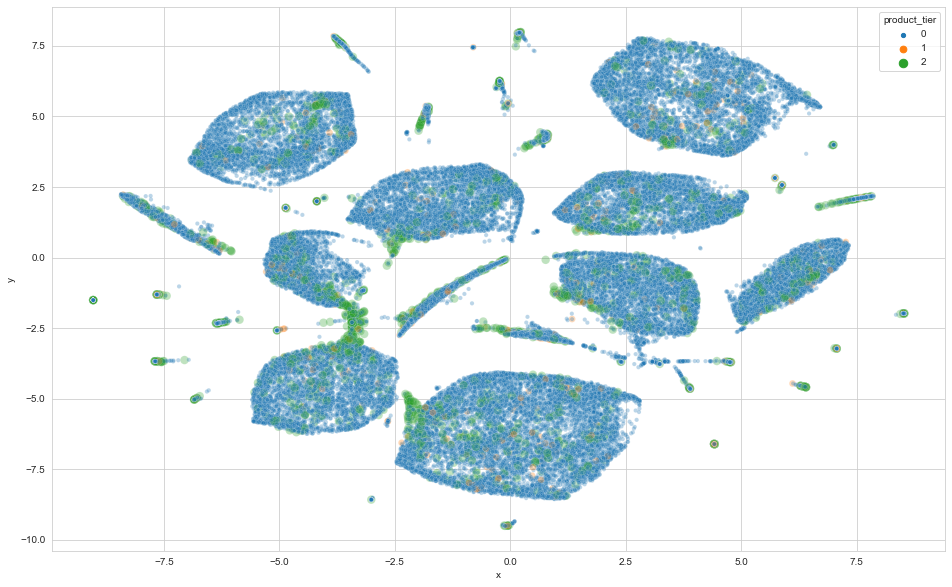

In [70]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x='x', 
    y='y',
    hue='product_tier',
    size='product_tier',
    data=tsne_results,
    palette='tab10',
    alpha=0.3
)

The data looks very difficult to model. The 3 classes for <b>product_tier</b>. The classes are hardly distinguishable. With the imbalanced classes, the modelling only becomes more difficult. 

The class for 'Plus' is completely indistinguishable against 'Basic'. Even if we create a very high sensitivity and specifivity based model, the f1-score for class 'Basic' will be awful. <b><i>Its easy to assume that modelling for product_tier would be a lost casue</i></b>. 

The best algorithms to train the model would be either boosting based or an SVM model. We will try training a XGBoost Model and then an SVM model. We will train two different XGB models, one with an assigned class weight and another with data over-sampled with SMOTE to mitigate the issue of imbalanced class.

But first, lets split the data.

In [71]:
from sklearn.model_selection import train_test_split

In [72]:
X_train_classification, X_test_classification, y_train_classification, y_test_classification = train_test_split(
                                                    data_classification.drop('product_tier', axis=1), 
                                                    data_classification['product_tier'], 
                                                    test_size=0.33, 
                                                    random_state=786)

<h3>Modelling - Classification

Before we dive deeper into modelling for<b> product_tier</b>, there are few assumptions we have to take based on our analysis of the data:
* The data is too diverse to accractely predict all the classes, there seems to be very little seperation between the classes. For XGB, we would need some big parameter grid to tune with.
* Because of the non-seperated classes, for SVM the most successful model will be one with either a sigmoid or a rbf kernel. This will allow the model to project the data onto a higher dimension so that we can be seperated via hyper-planes.

In [73]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestRegressor
from xgboost.sklearn import XGBClassifier, XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.utils import class_weight

Defining the class weights for XGBoost Model

In [74]:
class_weights = list(class_weight.compute_class_weight('balanced',
                                             np.unique(y_train_classification),
                                             y_train_classification))
w_array = np.ones(y_train_classification.shape[0], dtype = 'float')
for i, val in enumerate(y_train_classification):
    w_array[i] = class_weights[val-1]

w_array, class_weights

(array([11.06308017, 11.06308017, 11.06308017, ..., 11.06308017,
        11.06308017, 11.06308017]),
 [0.34632403444814286, 45.16709732988803, 11.063080168776372])

Defining the parameter grid for XGBoost

In [75]:
xgb_params = {  
                "learning_rate":[0.01,0.05,0.1,0.3,0.5],
                "gamma":[i/10.0 for i in range(0,5)],
                "max_depth": [2,3,4,5,6,7,8],
                "min_child_weight":[1,2,5,10],
                "max_delta_step":[0,1,2,5,10],
                "subsample":[i/10.0 for i in range(5,10)],
                "colsample_bytree":[i/10.0 for i in range(5,10)],
                "colsample_bylevel":[i/10.0 for i in range(5,10)],
                "reg_lambda":[1e-5, 1e-2, 0.1, 1, 100], 
                "reg_alpha":[1e-5, 1e-2, 0.1, 1, 100],
                "n_estimators":[100,500,700,1000]
             }


Initializing the XGBClassifier.

PS: I had a GPU machine, and have utilized it. Once can simply remove 'gpu_id=0' to train it over a system with no GPU.

In [76]:
xgb = XGBClassifier(objective='multi:softprob', gpu_id=0, eval_metric='mlogloss')

<b>Model Training - XGB - Classification</b>

Training the XGB model over RandomSearchCV with CV value as 3. 

In [77]:
n_iter = 10

random_search = RandomizedSearchCV(xgb, param_distributions=xgb_params,
                                 cv=3)

In [78]:
random_search.fit(X_train_classification, y_train_classification, verbose=1, sample_weight=w_array)

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           eval_metric='mlogloss', gamma=None,
                                           gpu_id=0, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=No...
                   param_distributions={'colsample_bylevel': [0.5, 0.6, 0.7,
                                                              0.8, 0.9],
                               

Analysing the best parameters for the trained model

In [79]:
random_search.best_params_

{'subsample': 0.7,
 'reg_lambda': 0.1,
 'reg_alpha': 1e-05,
 'n_estimators': 700,
 'min_child_weight': 5,
 'max_depth': 8,
 'max_delta_step': 1,
 'learning_rate': 0.5,
 'gamma': 0.0,
 'colsample_bytree': 0.8,
 'colsample_bylevel': 0.7}

The worrying thing about the above parameters is the max_depth (which is 7). This suggests that the algorithm had to choose a deeper tree i.e. it had to compute a complicated tree structure to make the model work. This is in-tune with our assumption that there are not enough features that explain the model well.

<b>Model Evaluation - XGB - Classification

In [80]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [81]:
y_pred_classification = random_search.predict(X_test_classification)

In [82]:
accuracy_score(y_pred_classification, y_test_classification)

0.9752216500832398

The accuracy is high, but its meaniningless as the data is outrageously imbalanced. Trusting on the accuracy to say the model is good is beleving that the one deposed prince of Nigeria, does really want to give all his father's riches to you.

In [83]:
print(classification_report(y_pred_classification, y_test_classification))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     25196
           1       0.03      0.31      0.05        16
           2       0.59      0.71      0.64       617

    accuracy                           0.98     25829
   macro avg       0.54      0.67      0.56     25829
weighted avg       0.98      0.98      0.98     25829



As we had assumed, the model performs badly for class 1 i.e. 'Plus'. 

<b>Oversampling the Minority</b>

Next, we train the model with data over-samples using SMOTE. SMOTE or <b>S</b>ynthetic <b>M</b>inority <b>O</b>versampling <b>TE</b>chnique uses KNN based Kernel to over-sample the minority class.

In [84]:
from imblearn.over_sampling import SMOTE

As the data is densely packed, we would have to choose a higher number of k_neighbours because this will help us to create better synthetic examples.

In [85]:
oversample = SMOTE(k_neighbors=50)
X, y = oversample.fit_resample(X_train_classification, y_train_classification)

Is the data really over-sampled?

In [86]:
y.value_counts()

0    50472
1    50472
2    50472
Name: product_tier, dtype: int64

Yeppers.

<b>Model Training - XGB with Oversampled Data - Classification

Creating another instance of RandomSearchCV with scoring as 'accuracy' as the classes are balanced. We choose accuracy as the metrics as the classes are now balanced.

In [87]:
random_search_with_SMOTE_data = RandomizedSearchCV(xgb, scoring='accuracy', param_distributions=xgb_params,
                                 cv=3)

In [88]:
random_search_with_SMOTE_data.fit(X, y, verbose=1)

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           eval_metric='mlogloss', gamma=None,
                                           gpu_id=0, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=No...
                                        'colsample_bytree': [0.5, 0.6, 0.7, 0.8,
                                                             0.9],
                                 

<b>Model Evaluation - XGB with Over Sampled Data - Classification

In [89]:
y_pred_2 = random_search_with_SMOTE_data.predict(X_test_classification)

In [90]:
accuracy_score(y_pred_2, y_test_classification)

0.9740214487591466

In [91]:
print(classification_report(y_pred_2, y_test_classification))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     25122
           1       0.09      0.25      0.13        63
           2       0.61      0.69      0.65       644

    accuracy                           0.97     25829
   macro avg       0.56      0.64      0.59     25829
weighted avg       0.98      0.97      0.98     25829



Eventhough we tightly oversampled the data for the minority classes, we couldn't achieve a better precision or recall for the minority class i.e. 'Plus' and 'Premium'. 

For us, the recall is of utmost importance and not precision. Because, even if we predict a Basic product tier as Premium its not a big issue. But predicting Premium product_tier as Basic would be disastrous. 

<b>Model Training - SVM Model with Class Weights  - Classification

In [92]:
from sklearn import svm

First, we define the parameter grid for SVM.

In [93]:
svm_params = {
                'C':            [0.1, 1, 10, 100],
                'kernel':       ['linear', 'rbf', "sigmoid"], 
                'gamma':        np.arange( 0.0, 10.0+0.0, 0.1 ).tolist(),
                'coef0':        np.arange( 0.0, 10.0+0.0, 0.1 ).tolist(),
                'class_weight': ['balanced']
            }

In [94]:
random_search_svm = RandomizedSearchCV(svm.SVC(), param_distributions=svm_params, cv=3, verbose=1) 

Training the SVM RandomizedSearchCV model.

In [ ]:
random_search_svm.fit(X_train_classification, y_train_classification)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


Analysing the best parameters for the trained model.

In [ ]:
random_search_svm.best_params_

As we had noted, a SVM model with RBF Kernel would be the best one. However, the high value of C explains that our model. 

The C parameter tells the SVM optimization how much you want to avoid misclassifying each training example. For large values of C, the optimization will choose a smaller-margin hyperplane if that hyperplane does a better job of getting all the training points classified correctly.The high value of C is a confirmation of our assumption that the classes are jam-packed and not easily seperable.

<b>Model Evaluation - SVM Model with Class Weights - Classification

In [ ]:
y_pred_classification_svm = random_search_svm.predict(X_test_classification)

In [ ]:
accuracy_score(y_pred_classification_svm, y_test_classification)

The accuracy is high, but its meaniningless as the data is outrageously imbalanced. Trusting on the accuracy to say the model is good is beleving that the one deposed prince of Nigeria, does really want to give all his father's riches to you.

In [ ]:
print(classification_report(y_pred_classification_svm, y_test_classification))

The problems that were prominent with XGB, are also prominent for SVM. The model fails to accurately differentiate between the 'Plus' and 'Basic'. 

Next, we move on to the regression problem to predict the details views

<h3> Modelling Regression

The first thing we have to make sure is that we do not use the <b>ctr</b> column. Reasons? Its a column calculated on the basis of detail_views. So it would be inappropriate to use it.


In [ ]:
df.select_dtypes(exclude=['object']).reset_index(drop=True).drop('ctr', axis=1)

In [ ]:
data_regression = pd.concat([df.select_dtypes(exclude=['object']).reset_index(drop=True).drop('ctr', axis=1),
                             df.replace({"product_tier": label_encoding_dict})['product_tier'].reset_index(drop=True), 
                             low_dim_make_name], axis=1)

In [ ]:
data_regression.head()

In [ ]:
data_regression = data_regression.astype('float')

Creating the heatmap to understand the corealtion.

In [ ]:
sns.heatmap(data_regression.corr())

The corelation matrix skips out on some columns, we would have to investigate why it is so. However, all the columns are numeric i.e. of type flaot64.

As we would be using non-linear algorithms such as Random Forest and XGB Rgeressor, we would not need to scaled the data.

The choice of  non-linear algorithms can be explained by the fact that the features do not have a very strict relation with the target. Only the search_views has a distorted linear relationship with detail_views while others not so much.

But first things first, let's split the data.

In [ ]:
X_train_regression, X_test_regression, y_train_regression, y_test_regression = train_test_split(
                                                    data_regression.drop('detail_views', axis=1), 
                                                    data_regression['detail_views'], 
                                                    test_size=0.33, 
                                                    random_state=786)

<b>Model Training - Random Forest  - Regression

Defining the parameter grid for Random Forest. I have chosen a shallow grid, as RF models do not utilize the GPU while training. The training ideally takes hours. To spearhead, the process I have meticulously chosen a small grid.

Also, we choose neg_mean_absolute_error for scoring. Because, we wish to avoid large errors with detail views. The mean for detail views is almost 91. Which suggests that we have a very small room for error.

In [ ]:
regressor = RandomForestRegressor()
para_grids = {
            "n_estimators" : [10,50,100, 80, 300, 500],
            "max_features" : ["auto", "log2", "sqrt"],
            "bootstrap"    : [True, False]
        }

rf = GridSearchCV(regressor, para_grids, scoring = 'neg_mean_absolute_error', cv=5)

Training the model

In [ ]:
rf.fit(X_train_regression, y_train_regression)

Choosing the best trained model

In [ ]:
forest = rf.best_estimator_

Analysing the feature importance

In [ ]:
fig = plt.figure(figsize=(10,6))
importance = forest.feature_importances_
    
sns.barplot(y=X_train_regression.columns, x=importance)
plt.show()

The above plot is consistent with our assumption. <b>search_views</b> is one of the most important feature to determine <b>detail_views</b>. The next important feature is price. As simple as it seems, more the price less will be the views. The age of the article is also an important feature as seen with first_registration_year.
    
As per our assumption, the regression model works as it should have worked.

<b>Model Evaluation - Random Forest - Regression

In [ ]:
y_preds_regression = forest.predict(X_test_regression)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [ ]:
mean_absolute_error(y_preds_regression, y_test_regression)

In [ ]:
y_test_regression.mean(), y_test_regression.std()

The MAE is a bit on the higher side, we might need to feature engineer more features to provide a better co-realtion apart from search_views feature.

<b>Model Training - XGB - Regression

In [ ]:
xgb = XGBRegressor(gpu_id=0)

Training the XGB model over RandomSearchCV with CV value as 3 and scoring as neg_mean_absolute_error. 

In [ ]:
n_iter = 10

random_search_regression = RandomizedSearchCV(xgb, scoring='neg_mean_absolute_error', param_distributions=xgb_params,
                                 cv=3)

Training the model.

In [ ]:
random_search_regression.fit(X_train_regression, y_train_regression)

In [ ]:
random_search_regression.best_params_

<b>Model Evaluation - XGB - Regression

In [ ]:
y_preds_regression_xgb = random_search_regression.predict(X_test_regression)

In [ ]:
mean_absolute_error(y_preds_regression_xgb, y_test_regression)

The MAE is even higher than that of RF. Simple reason, RF is better. 

<h3>Conclusions

The major question asked in the assignment was if we can predict the <b>product_tier</b> and the <b>detail_views</b> from the data provided. The simple answer to the question is that we can, but we need to ask is if we trust the models that we trained. The first model for classification has an abysmal f1 score  for the minority class.  None of the three classification models  where able to accurately and precisely predict the classes.  The simple reason for it can be that the data in hand is not enough for modelling.  Also the small number of data points for the minority classes is a cause of concern.

For the  regression problem to predict detail_views, we need better features that can provide robust co-realtion with the target. So far, we have search_views which alone is not able to provide us with a good model. There will be few things that we can do to make both the different types of model robust:

* Have more data points for the minority classes. 
* Have more features which describe the make of the article, features like horshe power of the article, color, utility.
* Have non-linear features such as images and photos of the artcile. If we can create a subsidiary model that takes in the image of the article and then provides a score for the attractiveness of the article. Then this score can be genuinely productive is telling us the detail_views. Simple rule of more attractive articles garner more views can explain the co-relation.

